# Assignment 6:  Topic Modeling with Latent Semantic Analysis

Latent Semantic Analysis (LSA) is a method for finding latent similarities between documents treated as a bag of words by using a low rank approximation. It is used for document classification, clustering and retrieval. For example, LSA can be used to search for prior art given a new patent application. In this homework, we will implement a small library for simple latent semantic analysis as a practical example of the application of SVD. The ideas are very similar to PCA. SVD is also used in recommender systems in an similar fashion (for an SVD-based recommender system library, see [Surpise](http://surpriselib.com). 

We will implement a toy example of LSA to get familiar with the ideas. If you want to use LSA or similar methods for statistical language analysis, the most efficient Python libraries are probably [gensim](https://radimrehurek.com/gensim/) and [spaCy](https://spacy.io) - these also provide an online algorithm - i.e. the training information can be continuously updated. Other useful functions for processing natural language can be found in the [Natural Language Toolkit](http://www.nltk.org/).

**Note**: The SVD from scipy.linalg performs a full decomposition, which is inefficient since we only need to decompose until we get the first k singluar values. If the SVD from `scipy.linalg` is too slow, please use the `svds` function in `scipy.sparse.linalg` or the `sparsesvd` function from the [sparsesvd](https://pypi.python.org/pypi/sparsesvd/) package to perform SVD instead.  You can install in the usual way with 
```
!pip install sparsesvd
```

Then import the following
```python
from sparsesvd import sparsesvd 
from scipy.sparse import csc_matrix 
```

and use as follows
```python
sparsesvd(csc_matrix(M), k=10)
```

In [1]:
### basic tools
import numpy as np
import pandas as pd
import scipy.linalg as la
import scipy.stats  as stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist

import itertools as it
from string import punctuation
from collections import Counter

import toolz as tz
import toolz.curried as c

### import data
import pickle

### sparce matrix
from sparsesvd    import sparsesvd 
from scipy.sparse import csc_matrix 

### print and plott
from pprint import pprint
import matplotlib.pyplot as plt

### func testing
import doctest

## Table of Contents <a name="toc"></a>
- [Question 01](#Q01)
- [Question 02](#Q02)
- [Question 03](#Q03)
- [Question 04](#Q04)

-----

# Question 01 <a name="Q01"></a>
[Back to top](#toc)

**Exercise 1 (20 points)**.  Calculating pairwise distance matrices.

Suppose we want to construct a distance matrix between the rows of a matrix. For example, given the matrix 

```python
M = np.array([[1,2,3],[4,5,6]])
```

the distance matrix using Euclidean distance as the measure would be
```python
[[ 0.000  1.414  2.828]
 [ 1.414  0.000  1.414]
 [ 2.828  1.414  0.000]] 
```
if $M$ was a collection of column vectors.

Write a function to calculate the pairwise-distance matrix given the matrix $M$ and some arbitrary distance function. Your functions should have the following signature:
```
def func_name(M, distance_func):
    pass
```

0. [Write a distance function for the Euclidean, squared Euclidean and cosine measures.](#Q10)
1. [Write the function using looping for M as a collection of row vectors.](#Q11)
2. [Write the function using looping for M as a collection of column vectors.](#Q12)
3. [Write the function using broadcasting for M as a collection of row vectors.](#Q13)
4. [Write the function using broadcasting for M as a collection of column vectors.](#Q14)

For 3 and 4, try to avoid using transposition (but if you get stuck, there will be no penalty for using transposition). Check that all four functions give the same result when applied to the given matrix $M$.

-----

## Q10 Write a distance function for the Euclidean, squared Euclidean and cosine measures. <a name = "Q10"></a>
[Back to Question 01](#Q01)

In [2]:
def dist_euclidean_sq(x, y = None, axis = 0):
    """calculate squared Euclidean distance of numpy vector x and y; if only one vector
    
    >>> x = np.array([3, 4])
    >>> y = np.array([0, 0])
    >>> z = np.array([-2, -8])
    >>> dist_euclidean_sq(x)
    25.0
    >>> dist_euclidean_sq(x, y)
    25.0
    >>> dist_euclidean_sq(y, x)
    25.0
    >>> dist_euclidean_sq(x, z)
    169.0
    """
    ### coerce the type to float
    x = x.copy().astype(np.float)
    
    ### calculate squared euclidean distance
    if y is None:
        # one vector only
        dist = np.sum(np.square(x), axis = axis)     
    else:
        # input two vectors
        dist = np.sum(np.square(x - y), axis = axis) 
        
    return dist

def dist_euclidean(x, y = None, axis = 0):
    """calculate Euclidean distance of numpy vector x and y
    
    >>> x = np.array([3, 4])
    >>> y = np.array([0, 0])
    >>> z = np.array([-2, -8])
    >>> dist_euclidean(x)
    5.0
    >>> dist_euclidean(x, y)
    5.0
    >>> dist_euclidean(y, x)
    5.0
    >>> dist_euclidean(x, z)
    13.0
    """
    dist_sq = dist_euclidean_sq(x, y, axis = axis) #, axis = axis)
    return(dist_sq**0.5)

def dist_cosine(x, y = None, axis = 0):
    """calculate cosince distance of input vectors
    >>> x = np.array([1, 1])
    >>> y = np.array([1, 0]) # x axis
    
    >>> d = dist_cosine(x, y)
    >>> np.allclose(d, 1 - np.cos(np.pi / 4)) # expect: 45 degree
    True
    
    >>> d = dist_cosine(y, x)                 # check d(x, y) = d(y, x)
    >>> np.allclose(d, 1 - np.cos(np.pi / 4)) # expect: 45 degree
    True
    
    >>> x = np.array([1, 3**0.5])
    >>> y = np.array([1, 0]) # x axis
    >>> d = dist_cosine(x, y)
    >>> np.allclose(d, 1 - np.cos(np.pi / 3)) # expect: 60 degree
    True
    
    >>> x = np.array([1, 3**0.5])
    >>> y = np.array([0, 1]) # y axis
    >>> d = dist_cosine(x, y)
    >>> np.allclose(d, 1 - np.cos(np.pi / 6)) # expect: 30 degree
    True
    """
    D = x * y
    D = np.sum(D, axis = axis) 
    
    norm1 = np.sqrt(np.sum(x * x, axis = axis))
    norm2 = np.sqrt(np.sum(y * y, axis = axis))

    dist = 1 - D / norm1 / norm2
    return dist

### test each function; if passed, no output from the run_docstring_examples
doctest.run_docstring_examples(dist_euclidean_sq, globals())
doctest.run_docstring_examples(dist_euclidean,    globals())
doctest.run_docstring_examples(dist_cosine,       globals())

## Q11 Write the function using looping for M as a collection of row vectors. <a name = "Q11"></a>
[Back to Question 01](#Q01)

In [3]:
def my_pdist_row_loop(M, distance_func):
    """calculate the pairwise-distance matrix given the matrix M and some arbitrary distance function
    
    Notes:
    - M is a collection of row vectors
    - using looping instead of broadcasting
    
    >>> M = np.array([[1,2,3],[4,5,6]])
    >>> dist = my_pdist_row_loop(M.T, dist_euclidean) # results
    >>> dist_exp = np.array([                         # expected
    ... [ 0.000,  1.414,  2.828],
    ... [ 1.414,  0.000,  1.414],
    ... [ 2.828,  1.414,  0.000]])
    
    >>> dist_round = np.round(dist, decimals = 3)
    >>> np.allclose(dist_round, dist_exp)
    True
    
    >>> dist = my_pdist_row_loop(M.T, dist_cosine) # results
    >>> dist_exp = np.array([
    ... [0.        , 0.00916983, 0.02381294],
    ... [0.00916983, 0.        , 0.00345424],
    ... [0.02381294, 0.00345424, 0.        ]])
    
    >>> dist_round = np.round(dist, decimals = 8)
    >>> np.allclose(dist_round, dist_exp)
    True
    """
    ### initialization
    nrow, ncol = M.shape
    idx        = np.arange(nrow)
    mat_dist   = np.zeros((nrow, nrow))
    
    ### loop through row pairs
    for idx01, idx02 in it.combinations(idx, 2):
        dist = distance_func(M[idx01], M[idx02])
        mat_dist[idx01, idx02] = dist
        mat_dist[idx02, idx01] = dist
        
    return mat_dist

### test each function; if passed, no output from the run_docstring_examples
doctest.run_docstring_examples(my_pdist_row_loop, globals())

## Q12 Write the function using looping for M as a collection of column vectors. <a name = "Q12"></a>
[Back to Question 01](#Q01)

In [4]:
def my_pdist_col_loop(M, distance_func):
    """calculate the pairwise-distance matrix given the matrix M and some arbitrary distance function
    
    Notes:
    - M is a collection of "column" vectors
    - using looping instead of broadcasting
    
    >>> M = np.array([[1,2,3],[4,5,6]])
    >>> dist = my_pdist_col_loop(M, dist_euclidean) # results
    >>> dist_exp = np.array([                         # expected
    ... [ 0.000,  1.414,  2.828],
    ... [ 1.414,  0.000,  1.414],
    ... [ 2.828,  1.414,  0.000]])
    
    >>> dist_round = np.round(dist, decimals = 3)
    >>> np.allclose(dist_round, dist_exp)
    True
    """
    return my_pdist_row_loop(M.T, distance_func)

### test each function; if passed, no output from the run_docstring_examples
doctest.run_docstring_examples(my_pdist_col_loop, globals())

## Q13 Write the function using broadcasting for M as a collection of row vectors.. <a name = "Q13"></a>
[Back to Question 01](#Q01)

For 3 and 4, try to avoid using transposition (but if you get stuck, there will be no penalty for using transposition). Check that all four functions give the same result when applied to the given matrix $M$.

In [5]:
def my_pdist_row_bcast(M, distance_func):
    """calculate the pairwise-distance matrix given the matrix M and some arbitrary distance function
    
    Notes:
    - M is a collection of "column" vectors
    - using broadcasting instead of looping
    
    >>> M = np.array([[1,2,3],[4,5,6]])                # collection of col vectors
    >>> dist = my_pdist_row_bcast(M.T, dist_euclidean) # results
    >>> dist_exp = np.array([                          # expected
    ... [ 0.000,  1.414,  2.828],
    ... [ 1.414,  0.000,  1.414],
    ... [ 2.828,  1.414,  0.000]])
    
    >>> dist_round = np.round(dist, decimals = 3)
    >>> np.allclose(dist_round, dist_exp)
    True
    
    >>> dist = my_pdist_row_bcast(M.T, dist_cosine) # results
    >>> dist_exp = np.array([
    ... [0.        , 0.00916983, 0.02381294],
    ... [0.00916983, 0.        , 0.00345424],
    ... [0.02381294, 0.00345424, 0.        ]])
    
    >>> dist_round = np.round(dist, decimals = 8)
    >>> np.allclose(dist_round, dist_exp)
    True
    """
    X = np.expand_dims(M, axis = 1)
    Y = np.expand_dims(M, axis = 0)

    return distance_func(X, Y, axis = 2)
    

### test each function; if passed, no output from the run_docstring_examples
doctest.run_docstring_examples(my_pdist_row_bcast, globals())

## Q14 Write the function using broadcasting for M as a collection of column vectors. <a name = "Q14"></a>
[Back to Question 01](#Q01)

For 3 and 4, try to avoid using transposition (but if you get stuck, there will be no penalty for using transposition). Check that all four functions give the same result when applied to the given matrix $M$.

In [6]:
def my_pdist_col_bcast(M, distance_func):
    """calculate the pairwise-distance matrix given the matrix M and some arbitrary distance function
    
    Notes:
    - M is a collection of "column" vectors
    - using broadcasting instead of looping
    
    >>> M = np.array([[1,2,3],[4,5,6]])                # collection of col vectors
    >>> dist = my_pdist_col_bcast(M, dist_euclidean) # results
    >>> dist_exp = np.array([                          # expected
    ... [ 0.000,  1.414,  2.828],
    ... [ 1.414,  0.000,  1.414],
    ... [ 2.828,  1.414,  0.000]])
    
    >>> dist_round = np.round(dist, decimals = 3)
    >>> np.allclose(dist_round, dist_exp)
    True
    """
    return my_pdist_row_bcast(M.T, distance_func)
    

### test each function; if passed, no output from the run_docstring_examples
doctest.run_docstring_examples(my_pdist_col_bcast, globals())

-----

# Question 02 <a name="Q02"></a>
[Back to top](#toc)

**Exercise 2 (20 points)**. Write 3 functions to calculate the term frequency (tf), the inverse document frequency (idf) and the product (tf-idf). Each function should take a single argument `docs`, which is a dictionary of (key=identifier, value=document text) pairs, and return an appropriately sized array. Convert '-' to ' ' (space), remove punctuation, convert text to lowercase and split on whitespace to generate a collection of terms from the document text.

- tf = the number of occurrences of term $i$ in document $j$
- idf = $\log \frac{n}{1 + \text{df}_i}$ where $n$ is the total number of documents and $\text{df}_i$ is the number of documents in which term $i$ occurs.

Print the table of tf-idf values for the following document collection

```
s1 = "The quick brown fox"
s2 = "Brown fox jumps over the jumps jumps jumps"
s3 = "The the the lazy dog elephant."
s4 = "The the the the the dog peacock lion tiger elephant"

docs = {'s1': s1, 's2': s2, 's3': s3, 's4': s4}
```

-----

Write 3 functions to calculate the term frequency (tf), the inverse document frequency (idf) and the product (tf-idf).

In [7]:
def str2gen(string):
    """convert a string to a word generator
    
    Convert '-' to ' ' (space), remove punctuation, convert text to lowercase and 
    split on whitespace to generate a collection of terms from the document text
    
    >>> string = ""
    >>> list(str2gen(string))                       
    []
    
    >>> string = "The quick brown fox"
    >>> list(str2gen(string))
    ['the', 'quick', 'brown', 'fox']
    """
    # translate table to convert punctuation into whitespace 
    # punctuation: !"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~
    transtab = str.maketrans("", "", punctuation)
    
    # process input string
    str_lst = tz.pipe(
        string,
        lambda x: x.replace('-', " "),   # Convert '-' to ' ' (space)
        lambda x: x.lower(),             # convert text to lowercase
        lambda x: x.translate(transtab), # Convert punctuation to whitespace
        lambda x: x.split(),             # split on whitespace
        c.filter(None)                   # filter empty string
    ) # end pipe
    
    #str_lst = string.lower().replace('-', ' ').translate(str.maketrans('', '', punctuation)).split()
    return(str_lst)
    

def get_tf(docs):
    """calculate the term frequency (tf) from docs, which is 
    a dictionary of (key=identifier, value=document text) pairs, 
    and return an appropriately sized array
    """
    ### counters
    tf_dict = {k: Counter(list(str2gen(v))) for k, v in docs.items()}
    tf_df = pd.DataFrame(tf_dict).fillna(0)
    return tf_df
    

def get_idf(docs):
    """idf = log (n / (1 + df_i)) where 
    - n    is the total number of documents and 
    - df_i is the number of documents in which term i occurs.
    """
    ### get tf matrix
    tf_df = get_tf(docs)
    
    ### nrow = number of terms
    ### ncol = number of documents
    nrow, ncol = tf_df.shape
    
    ### calculate
    df = tf_df > 0
    df = df.apply(np.sum, axis = 1)
    
    # log (n / (1 + df_i)
    return np.log(ncol / (1 + df))

def get_tfidf(docs):
    """get product of tf and idf"""
    ### get tf and idf
    doc_tf  = get_tf(docs)
    doc_idf = get_idf(docs)
    
    ### calculate the retrieve weight matrix (tf-idf)
    doc_tfidf = doc_tf.mul(doc_idf, axis = 0)
    return doc_tfidf

Create documents

In [8]:
s1 = "The quick brown fox"
s2 = "Brown fox jumps over the jumps jumps jumps"
s3 = "The the the lazy dog elephant."
s4 = "The the the the the dog peacock lion tiger elephant"

docs = {'s1': s1, 's2': s2, 's3': s3, 's4': s4}

get tf, idf, and product(tf-idf)

In [9]:
doc_tf  = get_tf(docs)
doc_idf = get_idf(docs)
doc_tfidf = get_tfidf(docs)

In [10]:
print(doc_tf)

           s1   s2   s3   s4
brown     1.0  1.0  0.0  0.0
dog       0.0  0.0  1.0  1.0
elephant  0.0  0.0  1.0  1.0
fox       1.0  1.0  0.0  0.0
jumps     0.0  4.0  0.0  0.0
lazy      0.0  0.0  1.0  0.0
lion      0.0  0.0  0.0  1.0
over      0.0  1.0  0.0  0.0
peacock   0.0  0.0  0.0  1.0
quick     1.0  0.0  0.0  0.0
the       1.0  1.0  3.0  5.0
tiger     0.0  0.0  0.0  1.0


In [11]:
print(doc_idf)

brown       0.287682
dog         0.287682
elephant    0.287682
fox         0.287682
jumps       0.693147
lazy        0.693147
lion        0.693147
over        0.693147
peacock     0.693147
quick       0.693147
the        -0.223144
tiger       0.693147
dtype: float64


In [12]:
print(doc_tfidf)

                s1        s2        s3        s4
brown     0.287682  0.287682  0.000000  0.000000
dog       0.000000  0.000000  0.287682  0.287682
elephant  0.000000  0.000000  0.287682  0.287682
fox       0.287682  0.287682  0.000000  0.000000
jumps     0.000000  2.772589  0.000000  0.000000
lazy      0.000000  0.000000  0.693147  0.000000
lion      0.000000  0.000000  0.000000  0.693147
over      0.000000  0.693147  0.000000  0.000000
peacock   0.000000  0.000000  0.000000  0.693147
quick     0.693147  0.000000  0.000000  0.000000
the      -0.223144 -0.223144 -0.669431 -1.115718
tiger     0.000000  0.000000  0.000000  0.693147


-----

# Question 03 <a name="Q03"></a>
[Back to top](#toc)

**Exercise 3 (20 points)**. 

1. Write a function that takes a matrix $M$ and an integer $k$ as arguments, and reconstructs a reduced matrix using only the $k$ largest singular values. Use the `scipy.linagl.svd` function to perform the decomposition. This is the least squares approximation to the matrix $M$ in $k$ dimensions.

2. Apply the function you just wrote to the following term-frequency matrix for a set of $9$ documents using $k=2$ and print the reconstructed matrix $M'$.
```
M = np.array([[1, 0, 0, 1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 1, 0, 0, 0, 0],
       [0, 1, 1, 2, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1]])
```

3. Calculate the pairwise correlation matrix for the original matrix M and the reconstructed matrix using $k=2$ singular values (you may use [scipy.stats.spearmanr](http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html) to do the calculations). Consider the fist 5 sets of documents as one group $G1$ and the last 4 as another group $G2$ (i.e. first 5 and last 4 columns). What is the average within group correlation for $G1$, $G2$ and the average cross-group correlation for G1-G2 using either $M$ or $M'$. (Do not include self-correlation in the within-group calculations.).

1. [Write function that perform SVD](#Q31)
2. [Apply the function to the term-frequency matrix](#Q32)
3. [Calculate pairwise correlation matrix for the original matrix and the reconstructed matrix](#Q33)

-----

## <a name = "Q31"></a> Q31. Write a function that takes a matrix $M$ and an integer $k$ as arguments, and reconstructs a reduced matrix using only the $k$ largest singular values. Use the `scipy.linagl.svd` function to perform the decomposition. This is the least squares approximation to the matrix $M$ in $k$ dimensions. 
[Back to Question 03](#Q03)

implement function; note that here I used <font color = "blue">sparsesvd instead of full svd in scipy.linalg</font>

In [13]:
def reconstruct_matrix(M, k):
    """reconstructs a reduced matrix using only the k largest singular values"""
    sM = csc_matrix(M)
    ut, s, vt = sparsesvd(sM, k = k)
    
    return ut.T @ np.diag(s) @ vt 

## <a name = "Q32"></a> Q32. Apply the function you just wrote to the following term-frequency matrix for a set of $9$ documents using $k=2$ and print the reconstructed matrix $M'$. 
[Back to Question 03](#Q03)

In [14]:
M = np.array([
    [1, 0, 0, 1, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 1, 0, 0, 0, 0],
    [0, 1, 1, 2, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 1, 0, 0, 0, 0],
    [0, 1, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 1, 1, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 1, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 1, 1]])

print(M.shape)

(12, 9)


In [15]:
M_re2 = reconstruct_matrix(M, 2)

print(M_re2.shape)
print(M_re2)

(12, 9)
[[ 0.16205797  0.40049828  0.37895454  0.46756626  0.17595367 -0.05265495
  -0.11514284 -0.15910198 -0.09183827]
 [ 0.14058529  0.36980077  0.32899603  0.40042722  0.16497247 -0.03281545
  -0.07056857 -0.09676827 -0.04298073]
 [ 0.15244948  0.50500444  0.35793658  0.41010678  0.23623173  0.02421652
   0.05978051  0.0868573   0.12396632]
 [ 0.25804933  0.84112343  0.60571995  0.69735717  0.39231795  0.03311801
   0.08324491  0.12177239  0.18737973]
 [ 0.44878975  1.23436483  1.0508615   1.26579559  0.55633139 -0.07378998
  -0.15469383 -0.20959816 -0.04887954]
 [ 0.15955428  0.5816819   0.37521897  0.41689768  0.27654052  0.05590374
   0.1322185   0.18891146  0.21690761]
 [ 0.15955428  0.5816819   0.37521897  0.41689768  0.27654052  0.05590374
   0.1322185   0.18891146  0.21690761]
 [ 0.21846278  0.54958058  0.51096047  0.62805802  0.24253607 -0.06541098
  -0.14252146 -0.19661186 -0.1079133 ]
 [ 0.09690639  0.53206438  0.22991365  0.21175363  0.26652513  0.13675618
   0.31462078 

## <a name = "Q33"></a> Q33. Calculate the pairwise correlation matrix for the original matrix M and the reconstructed matrix using $k=2$ singular values (you may use [scipy.stats.spearmanr](http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html) to do the calculations). Consider the fist 5 sets of documents as one group $G1$ and the last 4 as another group $G2$ (i.e. first 5 and last 4 columns). What is the average within group correlation for $G1$, $G2$ and the average cross-group correlation for G1-G2 using either $M$ or $M'$. (Do not include self-correlation in the within-group calculations.).
[Back to Question 03](#Q03)

### using original matrix M

get the group correlation within G1 (`rho_g1`), within G2  (`rho_g2`), and cross-group correlation (`rho_g12`)

In [16]:
### calculate pairwise corelation
rho, pval = stats.spearmanr(M)

### get within / cross correlation
rho_g1  = rho[:5, :5]
rho_g2  = rho[5:, 5:]
rho_g12 = rho[:5, 5:]

average within / cross group correlation

In [17]:
idx = np.triu_indices(5, 1)
print("within G1  ", np.mean(rho_g1[idx]))

idx = np.triu_indices(4, 1)
print("within G2  ", np.mean(rho_g2[idx]))

print("cross G1-G2", np.mean(rho_g12))

within G1   0.010577686629862793
within G2   0.43511771481980627
cross G1-G2 -0.3075621889055909


### using reconstructed matrix with k = 2

get the group correlation within G1 (`rho_g1`), within G2  (`rho_g2`), and cross-group correlation (`rho_g12`)

In [18]:
### calculate pairwise corelation
rho, pval = stats.spearmanr(M_re2)

### get within / cross correlation
rho_g1  = rho[:5, :5]
rho_g2  = rho[5:, 5:]
rho_g12 = rho[:5, 5:]

average within / cross group correlation

In [19]:
idx = np.triu_indices(5, 1)
print("within G1  ", np.mean(rho_g1[idx]))

idx = np.triu_indices(4, 1)
print("within G2  ", np.mean(rho_g2[idx]))

print("cross G1-G2", np.mean(rho_g12))

within G1   0.8666666666666668
within G2   0.9894736842105263
cross G1-G2 -0.6789473684210529


-----

# Question 04 <a name="Q04"></a>
[Back to top](#toc)

**Exercise 4 (40 points)**. Clustering with LSA

1. Begin by loading a PubMed database of selected article titles using 'pickle'. With the following:
```import pickle
docs = pickle.load(open('data/pubmed.pic', 'rb'))```

    Create a tf-idf matrix for every term that appears at least once in any of the documents. What is the shape of the tf-idf matrix? 

2. Perform SVD on the tf-idf matrix to obtain $U \Sigma V^T$ (often written as $T \Sigma D^T$ in this context with $T$ representing the terms and $D$ representing the documents). If we set all but the top $k$ singular values to 0, the reconstructed matrix is essentially $U_k \Sigma_k V_k^T$, where $U_k$ is $m \times k$, $\Sigma_k$ is $k \times k$ and $V_k^T$ is $k \times n$. Terms in this reduced space are represented by $U_k \Sigma_k$ and documents by $\Sigma_k V^T_k$. Reconstruct the matrix using the first $k=10$ singular values.

3. Use agglomerative hierarchical clustering with complete linkage to plot a dendrogram and comment on the likely number of  document clusters with $k = 100$. Use the dendrogram function from [SciPy ](https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

4. Determine how similar each of the original documents is to the new document `data/mystery.txt`. Since $A = U \Sigma V^T$, we also have $V = A^T U S^{-1}$ using orthogonality and the rule for transposing matrix products. This suggests that in order to map the new document to the same concept space, first find the tf-idf vector $v$ for the new document - this must contain all (and only) the terms present in the existing tf-idx matrix. Then the query vector $q$ is given by $v^T U_k \Sigma_k^{-1}$. Find the 10 documents most similar to the new document and the 10 most dissimilar. 

0. [Download pubmed documents](#Q40)
1. [Begin by loading a PubMed database of selected article titles using 'pickle'](#Q41)
2. [Perform SVD on the tf-idf matrix](#Q42)
3. [Use agglomerative hierarchical clustering with complete linkage](#Q43)
4. [Determine how similar each of the original documents is to the new document](#Q44)

## <a name = "Q40"></a> Q40 Download pubmed documents
[Back to Question 04](#Q04)

**Notes on the Pubmed articles**

These were downloaded with the following script.

```python
from Bio import Entrez, Medline
Entrez.email = "YOUR EMAIL HERE"
import pickle

try:
    docs = pickle.load(open('data/pubmed.pic', 'rb'))
except Exception as e:
    print(e)

    docs = {}
    for term in ['plasmodium', 'diabetes', 'asthma', 'cytometry']:
        handle = Entrez.esearch(db="pubmed", term=term, retmax=50)
        result = Entrez.read(handle)
        handle.close()
        idlist = result["IdList"]
        handle2 = Entrez.efetch(db="pubmed", id=idlist, rettype="medline", retmode="text")
        result2 = Medline.parse(handle2)
        for record in result2:
            title = record.get("TI", None)
            abstract = record.get("AB", None)
            if title is None or abstract is None:
                continue
            docs[title] = '\n'.join([title, abstract])
            print title
        handle2.close()
    pickle.dump(docs, open('data/pubmed.pic', 'wb'))
docs.values()
```

## <a name = "Q41"></a> Q41. Begin by loading a PubMed database of selected article titles using 'pickle'. With the following:
```
import pickle
docs = pickle.load(open('data/pubmed.pic', 'rb'))
```
Create a tf-idf matrix for every term that appears at least once in any of the documents. What is the shape of the tf-idf matrix? 

[Back to Question 04](#Q04)

load PubMed database of selected article titles

In [20]:
docs = pickle.load(open('data/pubmed.pic', 'rb'))

Create a tf-idf matrix for every term that appears at least once in any of the documents. What is the shape of the tf-idf matrix? 

In [21]:
pubmed_tfidf = get_tfidf(docs)
print(pubmed_tfidf.shape)

(6488, 178)


## <a name = "Q42"></a> Q42. Perform SVD on the tf-idf matrix to obtain $U \Sigma V^T$ (often written as $T \Sigma D^T$ in this context with $T$ representing the terms and $D$ representing the documents). If we set all but the top $k$ singular values to 0, the reconstructed matrix is essentially $U_k \Sigma_k V_k^T$, where $U_k$ is $m \times k$, $\Sigma_k$ is $k \times k$ and $V_k^T$ is $k \times n$. Terms in this reduced space are represented by $U_k \Sigma_k$ and documents by $\Sigma_k V^T_k$. Reconstruct the matrix using the first $k=10$ singular values.

[Back to Question 04](#Q04)

reconstruct with k = 10

In [22]:
pubmed_tfidf_re10 = reconstruct_matrix(pubmed_tfidf, k = 10)
pubmed_tfidf_re10

array([[ 0.04426728, -0.05128911,  0.17685338, ...,  0.02251461,
         0.12676269, -0.21022814],
       [ 0.00293911,  0.04269075,  0.00837922, ...,  0.0354431 ,
         0.02936161,  0.09236818],
       [ 0.00236582, -0.0758258 ,  0.0661755 , ..., -0.04051041,
        -0.00907675, -0.18027799],
       ...,
       [ 0.00796169,  0.00864913,  0.01581232, ...,  0.00579137,
         0.02599572,  0.01220511],
       [ 0.03053506,  0.12239512,  0.07019758, ...,  0.09256041,
         0.12828975,  0.19820361],
       [ 0.00819589,  0.01629815,  0.01721203, ...,  0.01149927,
         0.03127815,  0.0262137 ]])

# <a name = "Q43"></a> Q43. Use agglomerative hierarchical clustering with complete linkage to plot a dendrogram and comment on the likely number of  document clusters with $k = 100$. Use the dendrogram function from [SciPy ](https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

[Back to Question 04](#Q04)

SVD tf-idf matrix with k = 100 and find the document in the reduced space

In [23]:
Ut, S, Vt  = sparsesvd(csc_matrix(pubmed_tfidf), k = 100)
pubmed_red = np.diag(S) @ Vt

perform hierarchical clustering

In [24]:
pubmed_link = linkage(pubmed_red.T, method = 'complete', metric = 'cosine')

plot the dendrogram with the title as the labels

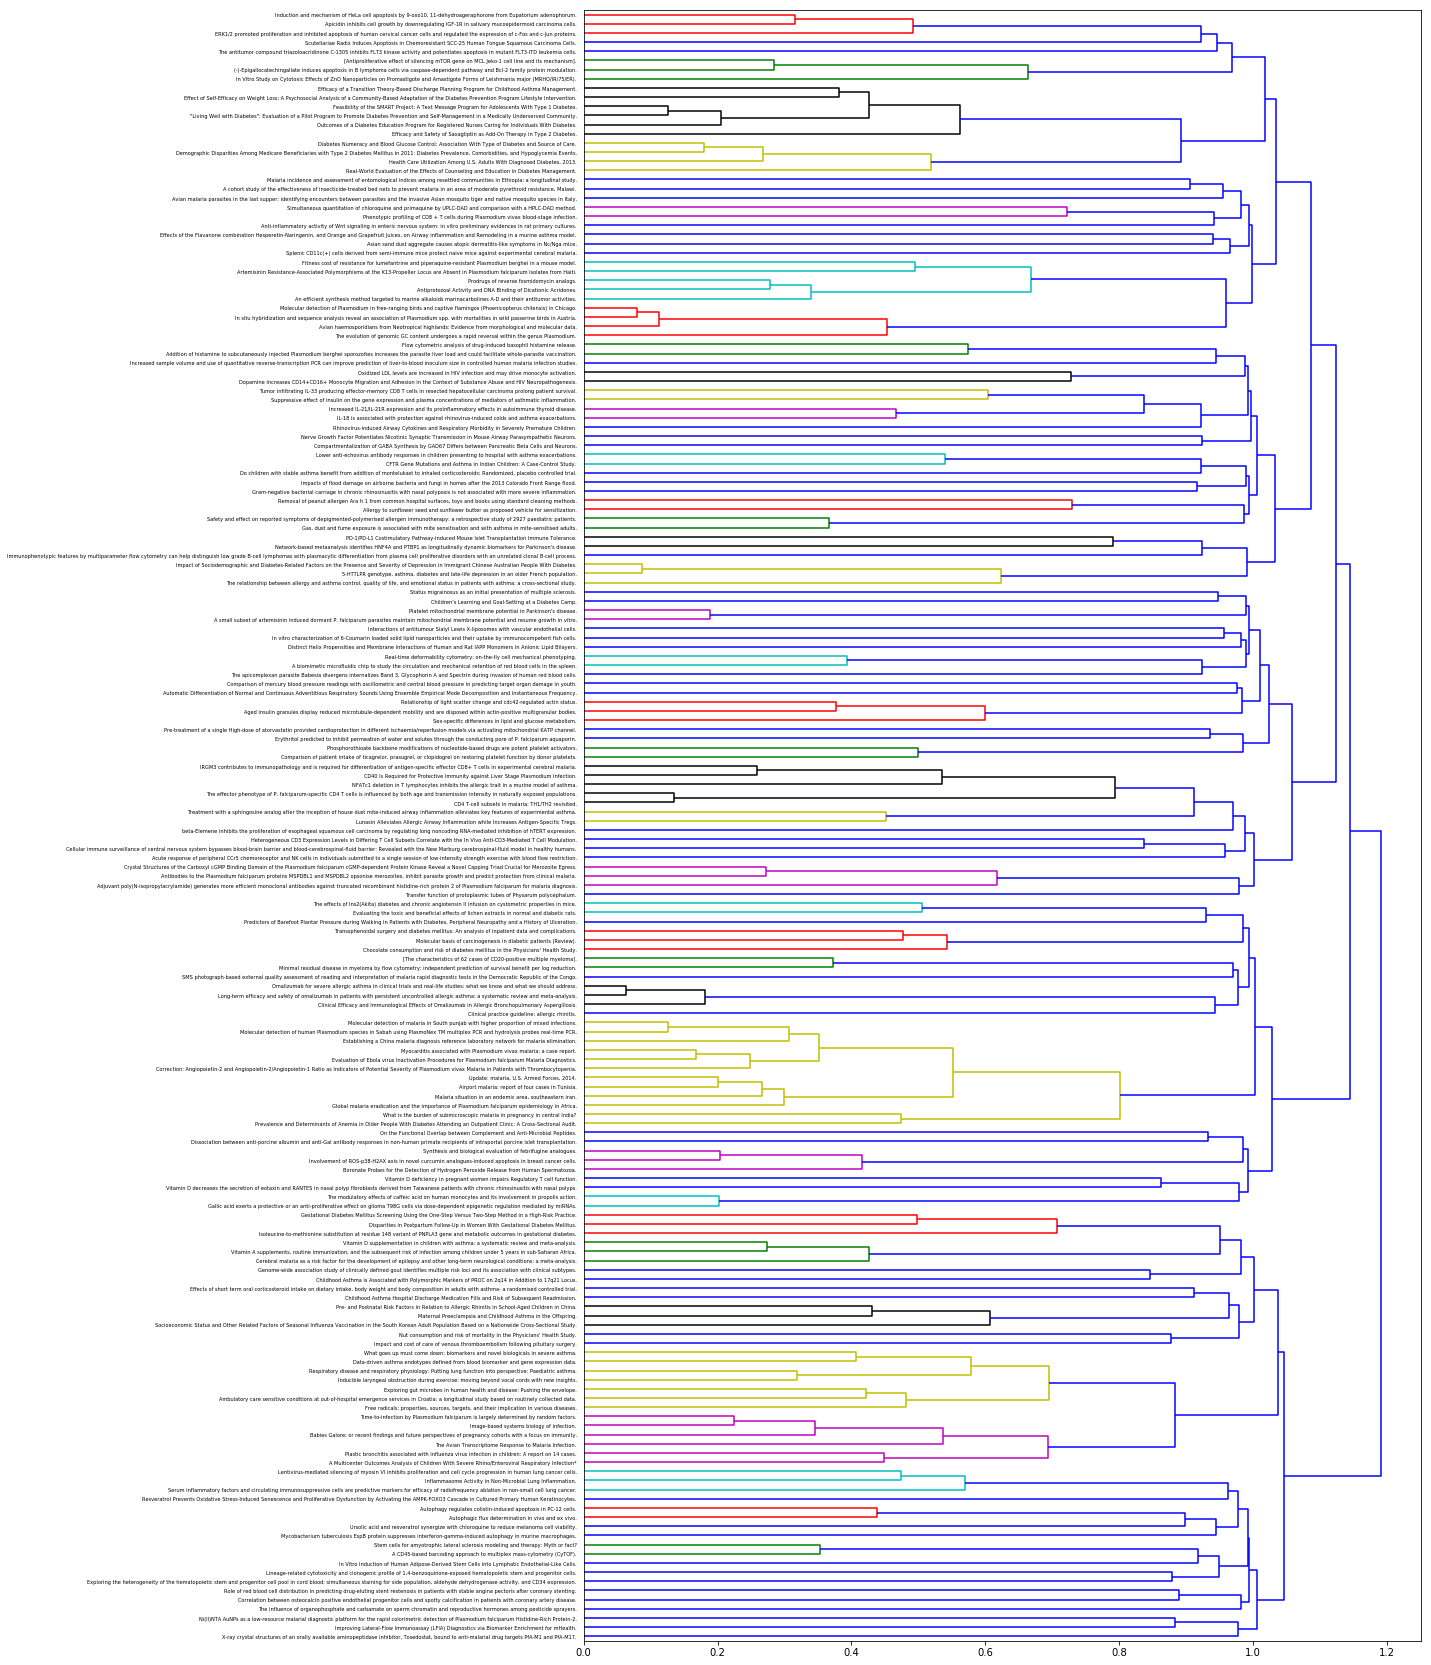

In [25]:
### set plot
plt.figure(figsize=(15, 30))
dendrogram(
    pubmed_link,
    orientation = "right",
    labels = pubmed_tfidf.columns.values
)
plt.show()

From the plot, there seems to be four large groups of document under the clustering using complete linkage.

Note: retrieve the cluster id
```
clusters = fcluster(Z, max_d, criterion = 'distance')
clusters = fcluster(Z, k,     criterion = 'maxclust')
```

In [26]:
clusters = fcluster(pubmed_link, 1.1, criterion = 'distance')

counts = np.array(list(Counter(clusters).values()))
idx = np.argsort(-counts)
counts[idx]

array([63, 47, 34, 34])

# <a name = "Q44"></a> Q44. Determine how similar each of the original documents is to the new document `data/mystery.txt`. Since $A = U \Sigma V^T$, we also have $V = A^T U S^{-1}$ using orthogonality and the rule for transposing matrix products. This suggests that in order to map the new document to the same concept space, first find the tf-idf vector $v$ for the new document - this must contain all (and only) the terms present in the existing tf-idx matrix. Then the query vector $q$ is given by $v^T U_k \Sigma_k^{-1}$. Find the 10 documents most similar to the new document and the 10 most dissimilar. 

[Back to Question 04](#Q04)

read in mystery.txt

In [27]:
mystery = ""

with open("./data/mystery.txt", "r") as f:
    for line in f:
        line = line.strip()
        mystery += line + " "
        
print(mystery)

﻿Intensive blood-glucose control with sulphonylureas or insulin compared with conventional treatment and risk of complications in patients with type 2 diabetes BACKGROUND: Improved blood-glucose control decreases the progression of diabetic microvascular disease, but the effect on macrovascular complications is unknown. There is concern that sulphonylureas may increase cardiovascular mortality in patients with type 2 diabetes and that high insulin concentrations may enhance atheroma formation. We compared the effects of intensive blood-glucose control with either sulphonylurea or insulin and conventional treatment on the risk of microvascular and macrovascular complications in patients with type 2 diabetes in a randomised controlled trial. METHODS: 3867 newly diagnosed patients with type 2 diabetes, median age 54 years (IQR 48-60 years), who after 3 months' diet treatment had a mean of two fasting plasma glucose (FPG) concentrations of 6.1-15.0 mmol/L were randomly assigned intensive p

In [28]:
docs = {"mystery": mystery}
mys_tfidf = get_tfidf(docs)

construct the vector v for the mystery document so that v is within the same space of the pubmed documents

In [29]:
v = pubmed_tfidf.join(mys_tfidf).fillna(0)['mystery']

Perform SVD decomposition; <font color = "blue">Here I chose k = 100</font>. Terms in this reduced space are represented by $U_k \Sigma_k$ and documents by $\Sigma_k V^T_k$. Therefore, we could find the subsplace all pubmed documents lie within

In [30]:
Ut, S, Vt  = sparsesvd(csc_matrix(pubmed_tfidf), k = 100)
pubmed_red = np.diag(S) @ Vt

### check shape; should be k x (number of documents)
print("Number of documents:", len(pubmed_tfidf.columns))
print("Reduced space shape:", pubmed_red.shape)

Number of documents: 178
Reduced space shape: (100, 178)


calculate the query vector q of the mystery document  
the query vector $q$ is given by $v^T U_k \Sigma_k^{-1}$

In [31]:
### get query vector q
v = np.array(v).reshape(-1, 1)
q = v.T @ Ut.T @ np.diag(1/S)

### check dimension of q; should be the same as k
q.shape

(1, 100)

calculate the distance of the mystery document and all other pubmed documents in the subspace; <font color = "blue">Here I used the cosine distance</font>

In [32]:
### initialization: row as observation
M = np.vstack([q, pubmed_red.T])

### get the distance of query (mystery) to the database (pubmed)
dist = my_pdist_row_loop(M, dist_cosine)[0]

### remove the query document itself
dist = dist[1:]

### choose the top 10 closest document and dissimilar document

From the content, we know the title of document is actually called

**Intensive blood-glucose control with sulphonylureas or insulin compared with conventional treatment and risk of complications in patients with type 2 diabetes (UKPDS 33). UK Prospective Diabetes Study (UKPDS) Group**

Therefore, the most similar document should be related to metabolism and the most dissimilar document should be related to other topics.

In [33]:
### order the document by distance
idx_docs  = np.argsort(-dist)
pubmed_id = np.array(pubmed_tfidf.columns)

idx_top  = idx_docs[:10]
idx_last = idx_docs[-10:]

### print out the results: 
### index of the document in docs, the title of the document
print("Top 10 Most Similar")
print("===========================")

for idx, string in zip(idx_top, pubmed_id[idx_top]):
    print('%03d' % idx, string)

print("\n")
print("Top 10 Most Dissimilar")
print("===========================")

for idx, string in zip(idx_last, pubmed_id[idx_last]):
    print('%03d' % idx, string)

Top 10 Most Similar
048 Diabetes Numeracy and Blood Glucose Control: Association With Type of Diabetes and Source of Care.
066 Feasibility of the SMART Project: A Text Message Program for Adolescents With Type 1 Diabetes.
076 Health Care Utilization Among U.S. Adults With Diagnosed Diabetes, 2013.
047 Demographic Disparities Among Medicare Beneficiaries with Type 2 Diabetes Mellitus in 2011: Diabetes Prevalence, Comorbidities, and Hypoglycemia Events.
049 Disparities in Postpartum Follow-Up in Women With Gestational Diabetes Mellitus.
130 Prevalence and Determinants of Anemia in Older People With Diabetes Attending an Outpatient Clinic: A Cross-Sectional Audit.
120 Outcomes of a Diabetes Education Program for Registered Nurses Caring for Individuals With Diabetes.
073 Gestational Diabetes Mellitus Screening Using the One-Step Versus Two-Step Method in a High-Risk Practice.
062 Evaluating the toxic and beneficial effects of lichen extracts in normal and diabetic rats.
058 Efficacy and S